# Clase 3

## Correccion de imagenes satelitales

Es esta clase veremos

1. Como abrir una imagen con python
2. Como escribir una imagen con python
3. Como realizar operaciones sobre las imagenes
4. Como utilizar el modulo py6s

### Apertura de imagenes

Para abrir imagenes en python utilizaremos el modulo de [gdal](www.gdal.org]) de python.

Comenzamos cargandolo, junto con los modulos de numpy.

In [17]:
# Cargo gdal y numpt
import gdal
# Bibliotecas para calculos
import numpy as np
import scipy as sp
# Bibliotecas de graficos
import matplotlib.pyplot as plt
%matplotlib inline  

Veremos ahora como

- Abrir la imagen

In [6]:
# Ponemos el nombre de la imagen

imagen_in = "../coberturas/imagenes/l1_l8_oli_2013-08-19.tif"

# cargo la imagen como un handle

imagen_ha = gdal.Open(imagen_in)

- Leer los parametros de la imagen

In [7]:
# Leo la cantidad de filas y columnas
Nx = imagen_ha.RasterXSize
Ny = imagen_ha.RasterYSize
N  = imagen_ha.RasterCount

# Lectura de parametros geoespaciales
geo  = imagen_ha.GetGeoTransform()
proj = imagen_ha.GetProjection()

- Cargar la imagen como un array de numpy

In [8]:
# Creo el array de con el numero de bandas elementos vacios
imagen = [[]]*N
# Leo la banda como array
# Sumamos +1 a i para obtener el numero de banda correcto
for i in range(N):
    imagen[i] = imagen_ha.GetRasterBand(i+1).ReadAsArray() 
    
# Para trabajar mas facilmente con la imagen la convertimos en float
# Convertimos la imagen en float32
imagen = np.array(imagen, dtype=np.float32)

### Escritura de imagenes

Veremos aqui como escribir un array de numpy en una imagen.

Usaremos todos los datos leidos de la imagen original

In [9]:
# Nombro el archivo de salida
file_out = "salida.tif"

# Obtengo el driver para el tipo de imagena utilizar
# En este caso, geotiff
driver = gdal.GetDriverByName("GTiff")

# Creo la imagen a de destino de Nx*Ny con N bandas y de tipo Float32
dst_ds = driver.Create(file_out,Nx,Ny,N,gdal.GDT_Float32)

# Asigno la proyeccion a la imagen
dst_ds.SetGeoTransform( geo )
dst_ds.SetProjection( proj )

# Guardo los arrays como bandas
for i in range(N):
    dst_ds.GetRasterBand(i+1).WriteArray(imagen[i])

# Guardo y cierro el archivo
dst_ds = None

### Operaciones sobre las imagenes

Realizar operaciones sobre las bandas de una imagen se realiza de la misma forma que hacerlo sobre una variable.

Despues de todo, convertimos nuestra imagen a un array de numpy para poder trabajar.

Veremos como caso concreto de uso de numpy y scipy para corregir una imagen por el metodo DOS1%.

Para ello:

1. Cargaremos las variables para operar con la imagen.
2. Convertiremos la imagen a reflectancia usando
$$\rho'_\lambda = \frac{G_\rho * DN + B_\rho}{\sin \theta_e}$$
3. Graficaremos el histograma de cada banda.
4. Restamos el valor de pixel obscuro.
$$ \rho_\lambda = \rho'_\lambda-\rho_{\lambda,min}$$
5. Guardaremos la imagen

In [10]:
# 1. Variables de la imagen
elevacion_grados =  40.94728285 #Angulo de elevacion solar
#Como coinciden los valores de gain y bias lo creo mas facil
gain = np.array([2.0e-5]*6)
#Como coinciden los valores de gain y bias lo creo mas facil
bias = np.array([-0.1]*6)   

In [14]:
# 2. Convierto la imagen a reflectancia
imagen_ref = [[]]*N # creo el array vacion

# Convierto a reflectancia
for i in range(N):
    imagen_ref[i] = (gain[i]*imagen[i]+bias[i])/np.sin(np.pi*elevacion_grados/180.0)

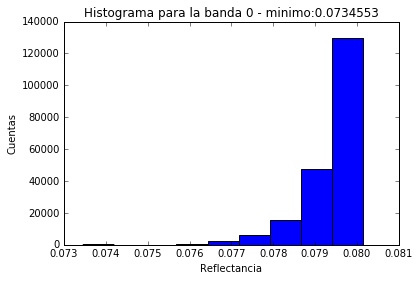

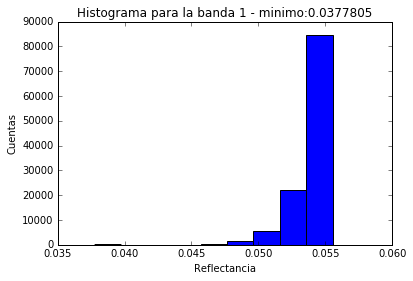

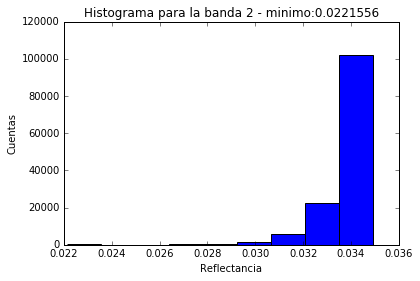

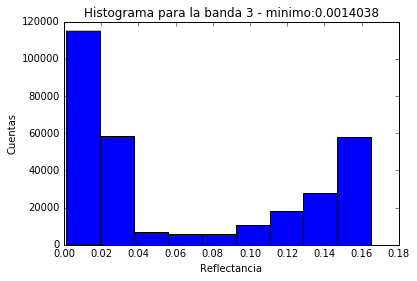

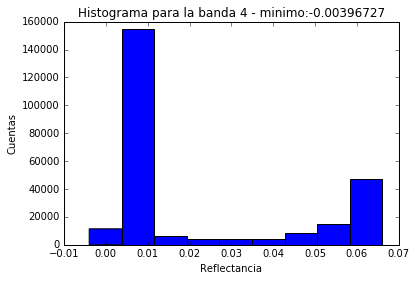

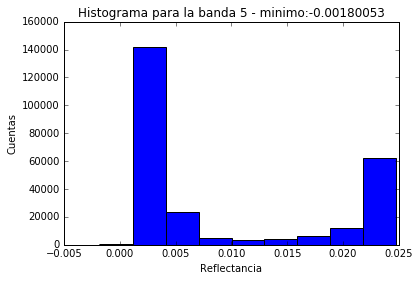

In [20]:
# 3. Calculo los histogramas por banda
for i in range(N):
    # Reshapeo el array para hacerlo mas rapido
    imagen_ref[i].shape = Nx*Ny
    # Busco el minimo y el maximo fijando el paso
    mi = np.min(imagen_ref[i])
    ma = np.percentile(imagen_ref[i],10)
    step = (ma-mi)/10
    #Grafico el histograma y lo muestor
    plt.hist(imagen_ref[i],bins=np.arange(mi,ma,step))
    plt.xlabel('Reflectancia')
    plt.ylabel('Cuentas')
    plt.title('Histograma para la banda '+str(i)+" - minimo:"+str(mi))
    plt.show()
    # Vuelvo al array a su estado original
    imagen_ref[i].shape = (Ny,Nx)

In [28]:
# 4. Restamos el valor del pixel obscuro
# Minimo
minimo = np.array([0.076, 
                  0.046,
                  0.027,
                  0.01,
                  0.01,
                  0.01])
# Reflectancia minima
dos = 1.0/100.0


imagen_dos = [[]]*N # creo el array vacion

# Convierto a reflectancia DOS1
for i in range(N):
    imagen_dos[i] = imagen_ref[i] - minimo[i] + dos
    # pongo a cero los valores genativos
    imagen_dos[i][imagen[i]<dos]=dos

In [29]:
# 5. Guardo la imagen
# Nombre del archivo de salida
file_out = "salida.tif"
# Datos que quiero guardar
data_out = imagen_dos

# Obtengo el driver para el tipo de imagena utilizar
# En este caso, geotiff
driver = gdal.GetDriverByName("GTiff")

# Creo la imagen a de destino de Nx*Ny con N bandas y de tipo Float32
dst_ds = driver.Create(file_out,Nx,Ny,N,gdal.GDT_Float32)

# Asigno la proyeccion a la imagen
dst_ds.SetGeoTransform( geo )
dst_ds.SetProjection( proj )

# Guardo los arrays como bandas
for i in range(N):
    dst_ds.GetRasterBand(i+1).WriteArray(data_out[i])

# Guardo y cierro el archivo
dst_ds = None